In [1382]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast

In [1383]:
# MAKE BACKTEST

# dfs = executer(n_workers=6)

# df_list = [pd.DataFrame(d) for d in dfs]
# df = pd.concat(df_list)
# df.head()

In [1605]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('twoway2.csv')
df['date'] = pd.to_datetime(df.date)

df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [1606]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')
df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [1607]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [1608]:
df.loc[(df.duplicated(subset=['date', 'sorted_pair'], keep='first'))].sort_values(by=['date', 'sorted_pair'])

,Unnamed: 0,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,...,open_price_scnd_stock,open_date,close_limit,stop_limit,halflife,days_open,data_ini,data_fin,setor,sorted_pair


In [1609]:
def result_calculator(row):
    
    
    long_result = row['price_fst_stock'] - row['open_price_first_stock']
    short_result = row['open_price_scnd_stock'] - row['price_scnd_stock']
    
#     long_result = row['open_price_first_stock'] - row['price_fst_stock']
#     short_result = row['price_scnd_stock'] - row['open_price_scnd_stock']

    result = long_result + short_result
    
    if row['residual_open'] > row['std_open_residual']:
        result = - result

    return result 

In [1610]:
cond = (df.status.isin(['True', 'close']))

In [1611]:
df.loc[cond, 'result'] = df.loc[cond].apply(lambda row: result_calculator(row), axis=1)

In [1612]:
# Cash Neutral

quant2 = df.loc[cond].open_price_first_stock / df.loc[cond].open_price_scnd_stock
quant1 = 1

# df.loc[cond,'quant1'] = quant1
# df.loc[cond,'quant2'] = quant2

long_result = df.loc[cond,'price_fst_stock'] - df.loc[cond,'open_price_first_stock']
short_result = df.loc[cond,'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']

result = (quant1 * long_result) + (short_result * quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_cash_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_cash_neutral'] = - result


In [1613]:
# Beta Neutral

quant2 = df.loc[cond].beta_open
quant1 = 1

result = (quant1) * (df.loc[cond, 'price_fst_stock'] - df.loc[cond, 'open_price_first_stock']) + (df.loc[cond, 'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']) * (quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_beta_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_beta_neutral'] = - result

In [1614]:
df.loc[df.status=='close'][['result', 'result_cash_neutral', 'result_beta_neutral']].sum()

result                 1.810000
result_cash_neutral    8.275256
result_beta_neutral   -2.607585
dtype: float64

In [1615]:
closed = df.loc[df.status=='close'].copy()

closed['is_profit'] = closed['result'] > 0
closed['is_profit_CN'] = closed['result_cash_neutral'] > 0
closed['is_profit_BN'] = closed['result_beta_neutral'] > 0


In [1616]:
print('resultado:', closed.result.sum())
print('acerto:', closed.is_profit.mean())
print('-'*30)
print('resultado cash neutral:', closed.result_cash_neutral.sum())
print('acerto cash neutral:', closed.is_profit_CN.mean())
print('-'*30)
print('resultado beta neutral:', closed.result_beta_neutral.sum())
print('acerto beta neutral:', closed.is_profit_BN.mean())

resultado: 1.8099999999999907
acerto: 0.5700934579439252
------------------------------
resultado cash neutral: 8.275255962189702
acerto cash neutral: 0.5607476635514018
------------------------------
resultado beta neutral: -2.607584594071765
acerto beta neutral: 0.5607476635514018


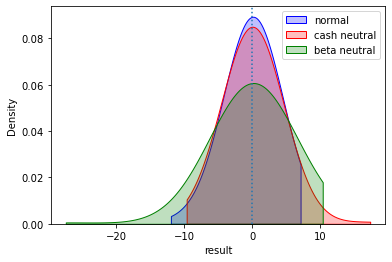

In [1617]:
sns.kdeplot(x=closed.result, color='blue', label='normal', bw_adjust=5, cut=0, fill=True)
sns.kdeplot(x=closed.result_cash_neutral, color='red', label='cash neutral', bw_adjust=5, cut=0, fill=True)
sns.kdeplot(x=closed.result_beta_neutral, color='green', label='beta neutral', bw_adjust=5, cut=0, fill=True)

plt.axvline(x=0, linestyle='dotted')
plt.legend()
plt.show()

In [1618]:
# Close by residual
closed.loc[abs(df.last_residual) < df.close_limit,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T

,sum,count
result,22.600000,15.0
result_cash_neutral,34.016017,15.0
result_beta_neutral,33.378024,15.0


In [1619]:
# stop by residual
closed.loc[abs(df.last_residual) > df.stop_limit,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T

,sum,count
result,-33.890000,17.0
result_cash_neutral,-28.682921,17.0
result_beta_neutral,-47.288969,17.0


In [1620]:
# stop by days
closed.loc[closed.days_open > closed.halflife,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T

,sum,count
result,-1.120000,80.0
result_cash_neutral,-3.761733,80.0
result_beta_neutral,3.225354,80.0


In [1582]:
df.loc[(df.status=='True') & (df.date=='2022-06-09')].result_beta_neutral.sum()

7.512766806409814

In [1583]:
# closed = closed.loc[closed.halflife.between(0,21)]

In [1584]:
closed.set_index('date').resample('6M')[['is_profit', 'is_profit_CN', 'is_profit_BN']].mean()

,is_profit,is_profit_CN,is_profit_BN
date,,,
2019-07-31,0.529412,0.647059,0.705882
2020-01-31,0.544118,0.514706,0.551471
2020-07-31,0.543147,0.558376,0.477157
2021-01-31,0.500000,0.527778,0.555556
2021-07-31,0.437956,0.452555,0.481752
2022-01-31,0.572727,0.572727,0.481818
2022-07-31,0.543210,0.518519,0.518519


In [1585]:
closed.set_index('date').resample('6M')[['result', 'result_cash_neutral', 'result_beta_neutral']].sum()

,result,result_cash_neutral,result_beta_neutral
date,,,
2019-07-31,5.29,9.518336,12.403014
2020-01-31,25.20,27.276701,30.699845
2020-07-31,54.08,69.323985,4.054589
2021-01-31,14.58,18.344694,24.181650
2021-07-31,-12.93,-12.330562,8.563534
2022-01-31,51.32,33.817997,35.868871
2022-07-31,28.68,22.344185,21.093808


[]

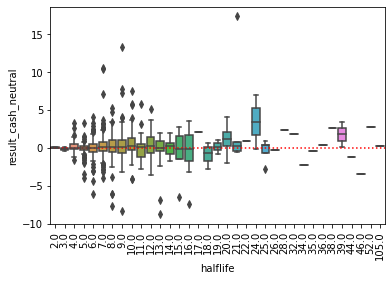

In [1601]:
sns.boxplot(x=closed.halflife, y=closed.result_cash_neutral)
plt.axhline(y=0, linestyle='dotted', color='red')
plt.xticks(rotation=90)
plt.plot()

In [1587]:
closed

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,data_fin,setor,sorted_pair,result,cash,result_cash_neutral,result_beta_neutral,is_profit,is_profit_CN,is_profit_BN
6,2019-07-12,"(AZUL4, GOLL4)",close,49.09,39.25,0.985577,0.959254,-0.997707,1.312356,1.262734,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",1.25,79.216987,0.361296,1.303075,True,True,True
9,2019-08-09,"(AZUL4, GOLL4)",close,55.47,40.71,0.947513,0.952723,3.919139,1.290817,1.258947,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",-1.28,90.679407,-0.916135,-1.336161,False,False,False
11,2019-08-13,"(AZUL4, GOLL4)",close,53.55,38.24,0.956020,0.958335,4.216166,1.351507,1.330845,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",1.21,90.418435,1.411143,1.189769,True,True,True
17,2019-08-21,"(AZUL4, GOLL4)",close,50.85,35.31,0.959594,0.965595,4.115253,1.430462,1.361101,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",-1.10,86.023983,-1.582256,-1.050705,False,False,False
24,2019-08-30,"(AZUL4, GOLL4)",close,47.10,33.32,0.966724,0.972513,2.148847,1.490611,1.449308,...,2019-12-31,Aéreas,"(AZUL4, GOLL4)",1.64,81.344582,1.547995,1.646655,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8288,2022-02-16,"(SOMA3, ALPA4)",close,13.28,27.09,0.213015,0.196235,1.604310,1.294916,1.245217,...,2022-07-01,Varejo,"(ALPA4, SOMA3)",-0.88,20.584487,0.125265,0.686099,False,True,True
8303,2022-04-26,"(VIIA3, CVCB3)",close,3.04,13.10,0.773178,0.782418,-0.954175,1.405617,1.518323,...,2019-12-31,Varejo,"(CVCB3, VIIA3)",2.73,17.442680,-0.233079,1.834052,True,False,True
8312,2022-06-03,"(VIIA3, DXCO3)",close,3.13,11.43,1.777047,1.703955,2.511529,1.555463,1.485031,...,2019-12-31,Varejo,"(DXCO3, VIIA3)",0.23,22.755227,-0.009919,0.486426,True,False,True
8322,2022-04-18,"(VIIA3, LREN3)",close,3.44,26.27,0.645305,0.652618,-1.346149,1.176511,1.150397,...,2019-12-31,Varejo,"(LREN3, VIIA3)",2.12,23.109350,-0.391229,1.077196,True,False,True


In [1588]:
closed_daily = closed.groupby('date').agg({'result':sum, 'result_cash_neutral':sum,'result_beta_neutral':sum})

In [1589]:
opens_by_date = df.loc[df.status=='True'].groupby('date').sum()
opens_by_date.cash.describe()

count     740.000000
mean      308.109296
std       183.450273
min         8.716091
25%       177.504978
50%       268.513254
75%       401.418093
max      1017.145180
Name: cash, dtype: float64

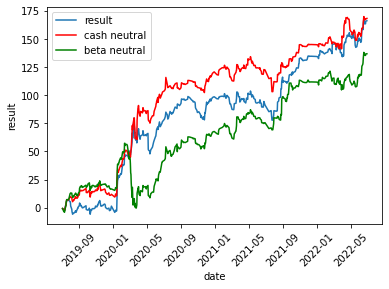

In [1592]:
sns.lineplot(x=closed_daily.index, y=closed_daily.result.cumsum(), label='result')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_cash_neutral.cumsum(),color='red', label='cash neutral')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_beta_neutral.cumsum(),color='green', label='beta neutral')


plt.xticks(rotation=45)
plt.show()

In [1593]:
closed_by_sector = closed.groupby('setor').agg(
    result = ('result', 'sum'),
    result_mean = ('result', 'mean'),
    result_CN = ('result_cash_neutral', 'sum'),
    result_mean_CN = ('result_cash_neutral', 'mean'),
    count = ('result', 'count'),
    accuracy = ('is_profit', 'mean'),
    accuracy_CN = ('is_profit_CN', 'mean')
)

closed_by_sector.sort_values(by='accuracy', ascending=False)

,result,result_mean,result_CN,result_mean_CN,count,accuracy,accuracy_CN
setor,,,,,,,
Papel e Celulose,11.46,1.432500,10.438215,1.304777,8,0.875000,1.000000
Construção Civil,-2.35,-0.261111,-3.543908,-0.393768,9,0.666667,0.333333
Saúde,59.18,0.730617,50.241403,0.620264,81,0.617284,0.592593
Bens Industriais,10.19,0.328710,10.728743,0.346088,31,0.612903,0.580645
Exploração de imóveis,1.58,0.175556,6.049808,0.672201,9,0.555556,0.666667
Aéreas,3.89,0.353636,3.621262,0.329206,11,0.545455,0.545455
Financeiro,86.06,0.321119,81.698847,0.304846,268,0.518657,0.526119
Utilidade Pública,-0.94,-0.004052,21.482830,0.092598,232,0.512931,0.512931
Varejo,3.34,0.058596,-19.063506,-0.334447,57,0.508772,0.473684


In [1594]:
closed_by_sector = closed.groupby('setor').agg(
    result = ('result', 'sum'),
    result_mean = ('result', 'mean'),
    result_CN = ('result_cash_neutral', 'sum'),
    result_mean_CN = ('result_cash_neutral', 'mean'),
    count = ('result', 'count'),
    accuracy = ('is_profit', 'mean'),
    accuracy_CN = ('is_profit_CN', 'mean')
)

closed_by_sector.sort_values(by='accuracy', ascending=False)

,result,result_mean,result_CN,result_mean_CN,count,accuracy,accuracy_CN
setor,,,,,,,
Papel e Celulose,11.46,1.432500,10.438215,1.304777,8,0.875000,1.000000
Construção Civil,-2.35,-0.261111,-3.543908,-0.393768,9,0.666667,0.333333
Saúde,59.18,0.730617,50.241403,0.620264,81,0.617284,0.592593
Bens Industriais,10.19,0.328710,10.728743,0.346088,31,0.612903,0.580645
Exploração de imóveis,1.58,0.175556,6.049808,0.672201,9,0.555556,0.666667
Aéreas,3.89,0.353636,3.621262,0.329206,11,0.545455,0.545455
Financeiro,86.06,0.321119,81.698847,0.304846,268,0.518657,0.526119
Utilidade Pública,-0.94,-0.004052,21.482830,0.092598,232,0.512931,0.512931
Varejo,3.34,0.058596,-19.063506,-0.334447,57,0.508772,0.473684


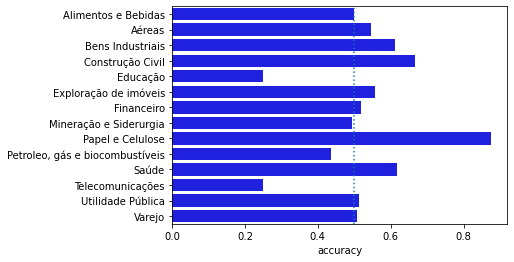

In [1595]:
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.accuracy, orient='h', color='blue')
# sns.barplot(y=closed_by_sector.index, x=closed_by_sector.accuracy_CN, orient='h', color='red')
plt.axvline(x=0.5, linestyle='dotted')

plt.ylabel(None)
plt.show()

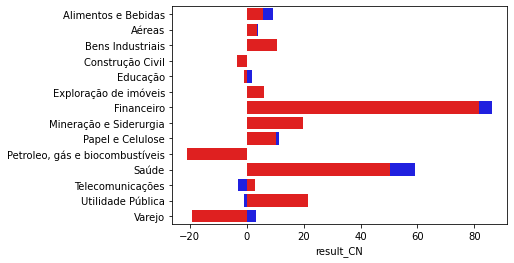

In [1596]:
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.result, orient='h', color='blue')
sns.barplot(y=closed_by_sector.index, x=closed_by_sector.result_CN, orient='h', color='red')

plt.ylabel(None)
plt.show()

In [1479]:
pair_closed = closed.groupby('sorted_pair').agg(
    result_sum=('result', 'sum'),
    result_mean=('result', 'mean'),
    result_sum_CN=('result_cash_neutral', 'sum'),
    result_mean_CN=('result_cash_neutral', 'mean'),
    count=('result', 'count'),
    accuracy=('is_profit', 'mean'),
    accuracy_CN=('is_profit_CN', 'mean'),
    sector=('setor', 'last')
    )

pair_closed.loc[pair_closed['count']>3].sort_values(by=['accuracy_CN', 'count'], ascending=False).head(25)

,result_sum,result_mean,result_sum_CN,result_mean_CN,count,accuracy,accuracy_CN,sector
sorted_pair,,,,,,,,
"(KLBN11, SUZB3)",11.46,1.432500,10.438215,1.304777,8,0.875000,1.000000,Papel e Celulose
"(TIMS3, VIVT3)",-3.15,-0.787500,2.917459,0.729365,4,0.250000,1.000000,Telecomunicações
"(BBDC3, BBDC4)",0.83,0.092222,1.356925,0.150769,9,0.666667,0.888889,Financeiro
"(BBAS3, ITSA4)",1.30,0.216667,3.460445,0.576741,6,0.666667,0.833333,Financeiro
"(ELET6, EQTL3)",6.32,0.632000,8.158183,0.815818,10,0.700000,0.800000,Utilidade Pública
"(EGIE3, SBSP3)",-1.31,-0.262000,-1.123499,-0.224700,5,0.400000,0.800000,Utilidade Pública
"(ITSA4, ITUB4)",1.20,0.240000,1.274313,0.254863,5,0.600000,0.800000,Financeiro
"(ABEV3, BRFS3)",15.57,1.946250,10.701986,1.337748,8,0.750000,0.750000,Alimentos e Bebidas
"(BBAS3, BBSE3)",4.36,0.545000,5.546111,0.693264,8,0.750000,0.750000,Financeiro


In [55]:
# pair_closed.to_excel('pares_parcial.xlsx')

In [56]:
bd = pd.read_excel("BD COMPLETO.xlsx")
bd.dropna(inplace=True)
bd.set_index('Data', inplace=True)

In [240]:
bd['log_ret'] = np.log(bd['BOVA11']/ bd['BOVA11'].shift())
bd

,ARZZ3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BOVA11,BRAP4,...,TAEE11,TIET11,VVAR3,YDUQ3,NTCO3,ITSA4,BPAC11,BOVV11,dol,log_ret
Data,,,,,,,,,,,,,,,,,,,,,
2017-04-11,28.5749,22.40,17.4028,28.1720,17.3703,17.6168,21.0011,9.78,62.42,17.2488,...,16.4007,10.4669,3.9803,14.2525,14.7845,6.8240,15.8492,64.46,3.531422,NaN
2017-04-12,28.5031,22.96,17.3301,27.7085,17.2553,17.4412,20.7890,9.87,61.68,16.2195,...,16.5075,10.3283,4.2291,14.5797,14.7213,6.7885,16.1625,64.00,3.519090,-0.011926
2017-04-13,28.7992,22.99,16.8300,26.2664,16.7844,16.9090,20.5403,9.95,60.80,16.3053,...,16.2939,10.3822,4.2291,13.9166,14.5948,6.6179,15.5868,62.93,3.536467,-0.014370
2017-04-17,28.6646,22.85,17.7756,27.4853,17.4415,17.6662,21.2791,10.00,62.25,16.5540,...,16.3865,10.4515,4.1793,14.7654,15.0277,6.7956,15.5783,64.44,3.483776,0.023569
2017-04-18,28.2609,23.91,17.9120,27.7514,17.4470,17.5619,21.2060,9.95,61.95,16.1166,...,16.5929,10.3052,4.3684,14.6769,14.9061,6.8525,15.2397,64.20,3.492744,-0.004831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,56.9600,26.10,56.0000,32.4254,19.3100,20.8500,26.2800,12.93,95.04,43.0300,...,28.7300,14.9000,18.0200,27.3100,49.7500,9.4600,79.1300,99.20,5.325000,-0.025555
2020-09-11,55.7500,26.58,56.0200,31.8971,18.8700,20.4600,25.4700,12.93,94.48,44.9000,...,28.3800,14.6500,17.9600,27.8900,51.6200,9.2700,78.1100,98.60,5.320500,-0.005910
2020-09-14,57.1700,28.25,58.7300,32.3600,19.1600,20.7000,25.8600,13.27,96.51,44.5500,...,28.6000,14.7700,18.3700,30.1100,53.2600,9.3800,81.4800,100.72,5.273000,0.021258


In [241]:
gpd = df.loc[df.status=='close'].groupby('date').sum().cumsum()
gpd.index = pd.to_datetime(gpd.index)

In [242]:
log_ret = bd.log_ret.rolling(103).std() * math.sqrt(252) * 100
bd['log_ret'] = log_ret
dd = gpd.join(bd, how='left')

In [243]:
dd.tail()

,Unnamed: 0,price_fst_stock,price_scnd_stock,beta,last_residual,std_residual,std_open_residual,residual_open,open_price_first_stock,open_price_scnd_stock,...,TAEE11,TIET11,VVAR3,YDUQ3,NTCO3,ITSA4,BPAC11,BOVV11,dol,log_ret
date,,,,,,,,,,,,,,,,,,,,,
2020-09-09,2023459,153315.2398,133838.780443,4598.712571,2438.870269,6027.001567,5508.004742,1587.831755,152065.9483,132933.602791,...,29.24,15.00,18.51,27.99,50.72,9.68,81.51,101.84,5.3125,27.819332
2020-09-10,2027911,153530.0298,134065.620443,4605.470703,2458.813394,6034.175484,5514.794709,1602.400746,152279.9083,133165.022891,...,28.73,14.90,18.02,27.31,49.75,9.46,79.13,99.20,5.3250,28.121526
2020-09-11,2033112,153700.4498,134203.500443,4609.935487,2463.226779,6040.043439,5520.014270,1607.310900,152451.1851,133304.013891,...,28.38,14.65,17.96,27.89,51.62,9.27,78.11,98.60,5.3205,28.080393
2020-09-14,2040552,154000.0398,134422.380443,4624.645357,2465.772731,6053.392315,5532.372547,1607.244930,152748.8051,133528.386891,...,28.60,14.77,18.37,30.11,53.26,9.38,81.48,100.72,5.2730,28.109877
2020-09-15,2045767,154226.1198,134554.700443,4643.035102,2468.318826,6064.113085,5542.253587,1601.723373,152973.6151,133665.316891,...,28.56,14.76,18.55,29.70,53.50,9.26,79.89,100.64,5.2780,28.052406


In [244]:
dd[['result', 'log_ret']].corr()

,result,log_ret
result,1.000000,0.723979
log_ret,0.723979,1.000000


In [245]:
px.line(dd[['result', 'log_ret']])

In [203]:
px.line(x=result_sum.index, y=result_sum.profit_loss)


In [196]:
bd.log_ret['2019'].std() * math.sqrt(252)

0.18208665089545323

In [193]:
(bd['BOVA11'] / bd['BOVA11'].shift()).std() * math.sqrt(252)

0.2925416460702591

In [179]:
bd['BOVA11'].pct_change()

Data
2017-04-11         NaN
2017-04-12   -0.011855
2017-04-13   -0.014267
2017-04-17    0.023849
2017-04-18   -0.004819
                ...   
2020-09-10   -0.025231
2020-09-11   -0.005892
2020-09-14    0.021486
2020-09-15   -0.000518
2020-09-16   -0.005702
Name: BOVA11, Length: 849, dtype: float64

In [ ]:
# Volatility
bd['log_ret'] = np.log(bd['BOVA11']/ bd['BOVA11'].shift())
anualized_vol = bd.log_ret.rolling(103).std() * math.sqrt(252) * 100
